# Structural Reconstruction of Ultrasound

Propagating ultrasound in a homogeneous medium is all fine and well, but how do we get an image out of that? Homogeneous media will give us homogeneous images; to form useful images, we'll need to think of sources of contrast. That's the topic of this notebook.

Greenleaf and Sehgal (1992) categorize sources of contrast in ultrasound in these 5 buckets (paraphrasing, as reported in Szabo 2013):

* Class 0: **Propagation properties**. Contrast can arise from absorption and attenuation as ultrasound travels through the medium and gets differentially absorbed and attenuated by the skull, CSF and brain.
* Class 1: **Sub-resolution scatterers**. Small scale fluctuations in compressibility/impedance in the homogeneous cause part of the ultrasound energy to be reflected back to the transducers. Sub-resolution scatterers (much smaller than the wavelength of ultrasound) are tiny, but they add up.
* Class 2: **Discrete scatterers**. Isolated targets that are large enough to be individually resolved, like calcifications, clots or large vessel walls. The lateral resolution of ultrasound images is on the order of $\lambda \frac{z}{D_{rx}}$, where $D_{rx}$ is the width of the receive aperture. In the simulations below, our receive aperture is 2.56 cm wide, and so 2.56 cm deep our lateral resolution will be on the order of $f_0 / c \approx 100 \mu m$ for a base frequency of 15 MHz.
* Class 3: **Specular interfaces/boundaries**. Reflections from large-scale surfaces, like ventricle walls. This can create very large signals.
* Class 4: **Motion of scatterers**. That includes endogenous moving scatterers like red blood cells and exogenous ones like microbubbles.

For this set of simulations, we'll focus on contrast that comes from lots of sub-resolution scatterers (class 1). In the next notebook, we'll focus on contrast that comes from the motion of scatterers (class 4).

Following our previous tutorial, we will focus on cases where we use plane waves to insonate the entire field, sweeping at multiple angles. As we'll see, plane wave insonation is critical to obtain fast framerates. For simplicity, we'll do everything in 2D.

# Scattering from a single small blip

Imagine a tiny inclusion---a scatterer---inside our homogeneous medium at position $(x_0, z_0)$, with the same density as the surrounding medium but a slightly different speed of wave propagation. When it's hit by a plane wave, some of the ultrasound will get reflected back, similar to how light gets partially reflected when there are changes in refraction index (think: air-water). 

To a first approximation, the backscatter will spread isotropically from the location of the scatterer---a monopole source---without changing the phase of the incoming wave. That means that if we send a plane wave down the z direction, we'll "see" the backscatter at a detector at position $(x, 0)$ at time:

$$\Delta t = \frac{1}{c} (z_0 + r)$$

With $r = \sqrt{(x - x_0)^2 + (z - z_0)^2}$.

And the measured pressure change will be inversely proportional to the square root of the distance:

$$\Delta p \propto 1/\sqrt{r}$$

Note that in 3d, the change in pressure is instead proportional to $1/r$. If the plane wave is at an angle $\beta$, we have that:

$$\Delta t = \frac{1}{c} (z_0 \cos \beta + x_0 \sin \beta + r)$$

**Note**: the exact directionality of the backscatter can get complicated (see Chapter 8 in Szabo 2013), but this isotropic approximation is fairly good for one important scatterer: red blood cells (see Figure 8.5).

In [1]:
1540 / 15E6

0.00010266666666666666

# Locating a scatterer

If we had just a single measurement of the time it takes for backscatter to arrive on the send plane, multiple locations would be compatible with that time delay:

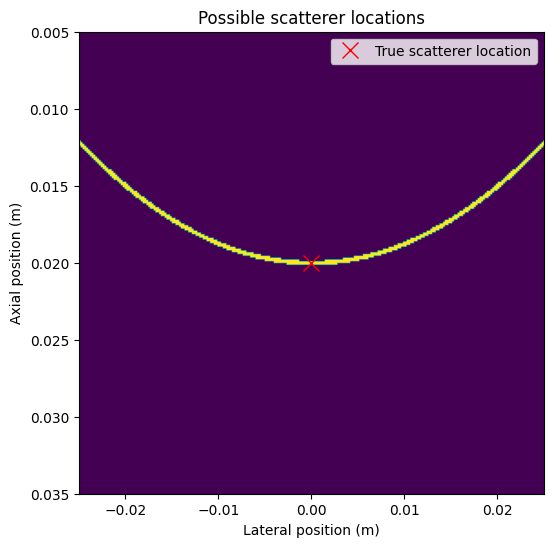

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import scipy.signal
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Optional, Literal

c = 1540  # speed of sound in m/s
x = 0
x_0, z_0 = 0, 0.02
delta_t = (z_0 + np.sqrt(z_0**2 + x_0**2)) / c

L = 0.05
n_points = 256
z_range = np.linspace(.005, .035, n_points)
x_range = np.linspace(-L/2, L/2, n_points)

xi, zi = np.meshgrid(x_range, z_range, indexing='xy')

delta_ts = (zi + np.sqrt(zi**2 + (xi - x)**2)) / c

cone_of_confusion = np.abs(delta_ts - delta_t) < 2e-7

plt.figure(figsize=(6, 6))
plt.imshow(cone_of_confusion, extent=[x_range[0], x_range[-1], z_range[-1], z_range[0]], aspect='auto')
plt.title("Possible scatterer locations")
plt.xlabel("Lateral position (m)")
plt.ylabel("Axial position (m)")
plt.xlim(-.025, .025)

plt.plot(x_0, z_0, 'rx', markersize=12, label="True scatterer location")
plt.legend()

The yellow curve corresponds to positions in the image compatible with the timing of the backscatter. It forms a parabola, which is a conic; call it the "[conic of confusion](https://en.wiktionary.org/wiki/cone_of_confusion)". With multiple measurements along the x axis, however, we can get a much better read on the position of the scatterer.

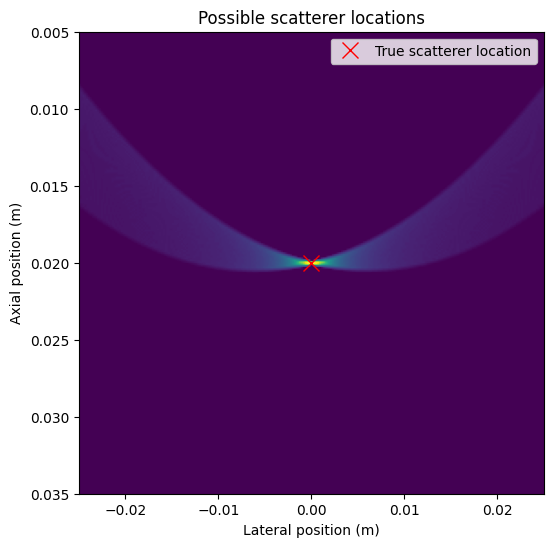

In [3]:
c = 1540  # speed of sound in m/s
cone_of_confusion = 0

dx = 0.0001
elem_pos = np.arange(-64, 64) * dx
for x in elem_pos:
    x_0, z_0 = 0, 0.02
    delta_t = (z_0 + np.sqrt(z_0**2 + (x_0 - x)**2)) / c

    L = 0.05
    n_points = 256
    xi, zi = np.meshgrid(x_range, z_range, indexing='xy')

    delta_ts = (zi + np.sqrt(zi**2 + (xi - x)**2)) / c

    cone_of_confusion += np.abs(delta_ts - delta_t) < 2e-7

plt.figure(figsize=(6, 6))
plt.imshow(cone_of_confusion, extent=[x_range[0], x_range[-1], z_range[-1], z_range[0]], aspect='auto')
plt.title("Possible scatterer locations")
plt.xlabel("Lateral position (m)")
plt.ylabel("Axial position (m)")
plt.xlim(-.025, .025)

plt.plot(x_0, z_0, 'rx', markersize=12, label="True scatterer location")
plt.legend()

We can enhance the lateral resolution by transmitting the plane wave at different angles:

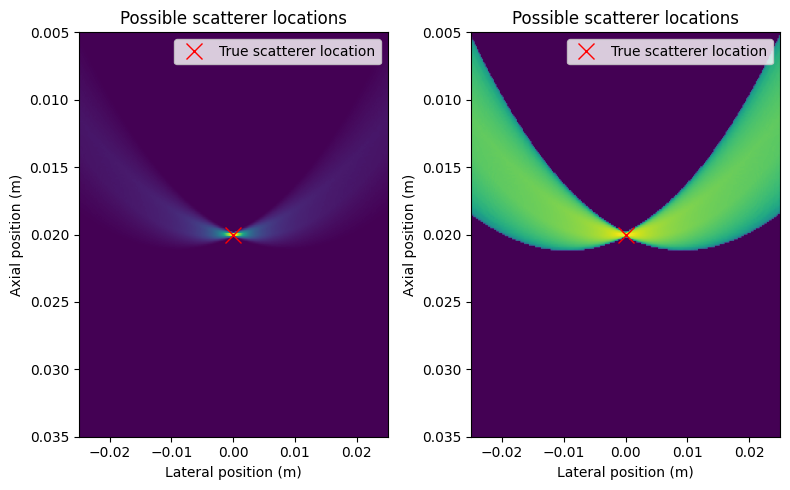

In [4]:
c = 1540  # speed of sound in m/s
cone_of_confusion = 0

for beta in np.deg2rad(np.linspace(-8, 8, 9, endpoint=True)):
    for x in elem_pos:
        x_0, z_0 = 0, 0.02
        delta_t = (z_0 * np.cos(beta) + x_0 * np.sin(beta) + np.sqrt(z_0**2 + (x_0 - x)**2)) / c

        L = 0.05
        n_points = 256

        xi, zi = np.meshgrid(x_range, z_range, indexing='xy')

        delta_ts = (zi * np.cos(beta) + xi * np.sin(beta) + np.sqrt(zi**2 + (xi - x)**2)) / c

        cone_of_confusion += np.abs(delta_ts - delta_t) < 2e-7

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(cone_of_confusion, extent=[x_range[0], x_range[-1], z_range[-1], z_range[0]], aspect='auto')
plt.title("Possible scatterer locations")
plt.xlabel("Lateral position (m)")
plt.ylabel("Axial position (m)")
plt.xlim(-.025, .025)

plt.plot(x_0, z_0, 'rx', markersize=12, label="True scatterer location")
plt.legend()

plt.subplot(122)
plt.imshow(np.log(cone_of_confusion + 1e-2), extent=[x_range[0], x_range[-1], z_range[-1], z_range[0]], aspect='auto')
plt.title("Possible scatterer locations")
plt.xlabel("Lateral position (m)")
plt.ylabel("Axial position (m)")
plt.xlim(-.025, .025)

plt.plot(x_0, z_0, 'rx', markersize=12, label="True scatterer location")
plt.legend()
plt.tight_layout()

Cool, right? We've shown that for one scatterer, by transmitting plane waves at different angles, and measuring at different positions on the surface, we can recover the location of the scatterer. The mechanism we used---taking all the constraints from the time lags measured, and adding the constraints together to recover the scatterer---is a toy version of the delay-and-sum algorithm.

Now, wouldn't it be easier to do this kind of echolocation if we had instead fired one transducer at a time at different locations on the x plane and measured their backscatter? That's how conventional B-mode ultrasound works. By using plane waves, however, we can scan through a small number of angles (~10) rather than each transducer (~256) individually, and thus get images much faster. A major advantage of plane wave transmission over raster scanning ultrasound is that we can obtain images at much higher framerates, which is critical for tracking movement of scatterers in the volume, as we'll see in the next notebook.

Indeed, the interframe interval with this plane wave scheme from the number of angles and the depth we desire to image:

In [5]:
depth = 0.05  # m
n_angles = 9
padding = 1.2
inter_frame_interval = padding * 2 * depth * n_angles / c
print(f"Inter-frame interval: {inter_frame_interval*1e3:.2f} ms ({1/inter_frame_interval:.1f} Hz)")

Inter-frame interval: 0.70 ms (1425.9 Hz)


That's fast!

# Simulating the signal at the receptors

Thus far, we've assumed that we've already estimated the time delay at the transducers, but what does the signal at the transducers look like in time? Let's assume that through apodization and custom waveform tricks in the first tutorial, we're sending true plane waves at angle $\beta$ in the medium, windowed through time with a window $G(t)$. Then at time t and position x, the pressure will look like this:

$$p(x, t) \propto \mathbf{Re} \left\{ \frac{G(t-\Delta t) \exp(i \omega t) \exp(-\alpha (z_0 \cos \beta + x_0 \sin \beta + r(x))) D(\theta)}{\sqrt{r(x)}} \right\} $$

Where $r(x)$ and $\Delta t$ are as before, and we've picked up an attenuation term from loss inside the medium, as well as a directional selectivity $D(\theta)$. Real transducers have a finite width $\Delta x$, which means that when backscattered waves are coming back at an angle, the transducer will integrate from areas of lower and higher pressure, and some of the pressure cancels out. This gives the transducers a small amount of direction selectivity:

$$D(\theta) = \text{sinc}(k \Delta x \sin \theta)$$

As usual, $k = \frac{\omega}{c}$ and $\sin \theta = \frac{x - x_0}{r}$. Here's what that looks for some typical values:

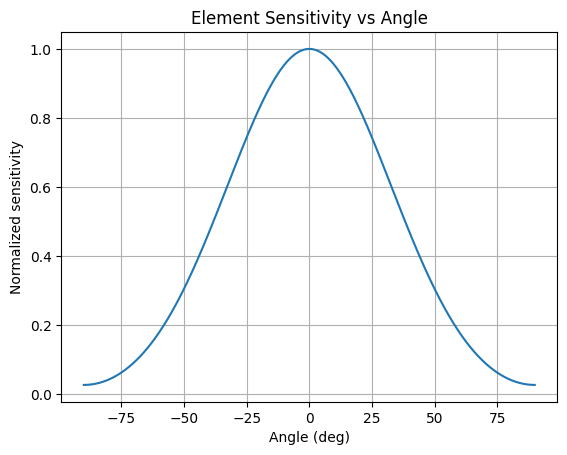

In [6]:
# Tunable parameters
c = 1540.0              # speed of sound [m/s]
f = 15e6                 # frequency [Hz]
lam = c / f             # wavelength [m]
k = 2*np.pi / lam       # wavenumber [rad/m]

b = .05e-3                # half-width of the transducer element [m]

# Angle sweep (degrees and radians)
angles_deg = np.linspace(-90, 90, 721)
angles_rad = np.deg2rad(angles_deg)

# Piston-like sinc directivity model used in the paper
# D(theta,k) = sinc(k * b * sin(theta)) where sinc(x) = sin(x)/x
x = k * b * np.sin(angles_rad)
D = np.sinc(x / np.pi)

D_norm = D / np.max(D)

plt.figure()
plt.plot(angles_deg, D_norm, label='sinc model (piston)')
plt.xlabel('Angle (deg)')
plt.ylabel('Normalized sensitivity')
plt.title('Element Sensitivity vs Angle')
plt.grid(True)
plt.show()


Putting all of these ideas together, we can generate the signals as we would see them at the transducers:

In [7]:
x_0, z_0 = 0.0, 0.02  # scatterer position

dx = 0.0001 # 100 um elements
b = dx / 2
elem_pos = np.arange(-64, 64) * dx  # positions of elements in meters
f_carrier = 15e6  # 15 MHz carrier frequency
c = 1540.0
omega = 2 * np.pi * f_carrier
k = omega / c

alpha = f_carrier / 1E6 / 8.686 * .58 * 100

# Temporal envelope
s_env = np.hanning(16)
Ne = len(elem_pos)

times = np.linspace(0, 4 * z_0 / c, 2048)
dt = (times[1] - times[0])
N_times = len(times)
betas = np.deg2rad(np.array((-8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0), dtype=np.float64))
signals = np.zeros((len(betas), Ne, N_times), dtype=np.complex128)

for i, beta in enumerate(betas):
    # Calculate the transmit delay
    r_tx = z_0 * np.cos(beta) + x_0 * np.sin(beta)
    tau_tx = r_tx / c
    
    for n in range(Ne):
        # receive delay
        r_rx = np.sqrt((x_0 - elem_pos[n])**2 + z_0**2)  # distance to scatterer at (x, 0.02)
        tau_rx = r_rx / c

        amplitude = np.exp(-alpha * (r_tx + r_rx)) * np.sinc(k * b * (x_0 - elem_pos[n]) / r_rx / np.pi) / np.sqrt(r_rx)
        
        # Assign to the closest index in times
        total_delay = tau_tx + tau_rx
        idx = int(total_delay / dt)

        phase = np.exp(-1j * omega * total_delay)
        
        # Nearest neighbor assignment
        g = np.zeros(N_times, dtype=np.complex128)
        g[idx] = phase

        # Convolution with envelope to obtain the received signal
        y = fftconvolve(g, s_env, mode='same')

        signals[i, n, :] = amplitude * y * np.exp(1j * omega * times)

real_signals = np.real(signals)

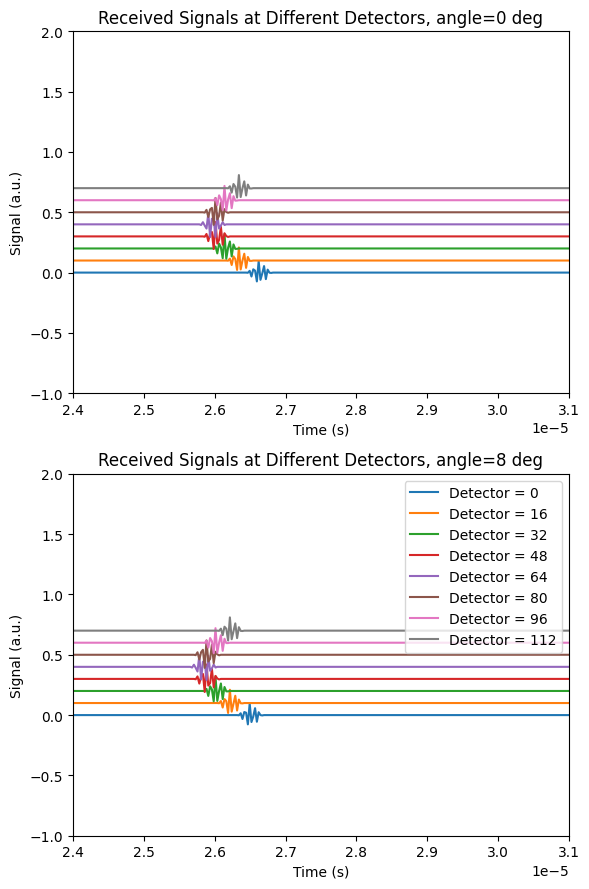

In [8]:
x_rg = (2.4E-5, 3.1E-5)
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(times, real_signals[4, ::16, :].T + np.arange(8)[None, :] * .1)
plt.xlabel('Time (s)')
#plt.legend([f'Detector = {i}' for i in np.arange(0, 128, 16)])
plt.ylabel('Signal (a.u.)')
plt.title('Received Signals at Different Detectors, angle=0 deg')
plt.xlim(x_rg)
plt.ylim(-1, 2)

plt.subplot(2, 1, 2)
plt.plot(times, real_signals[0, ::16, :].T + np.arange(8)[None, :] * .1)
plt.xlabel('Time (s)')
plt.legend([f'Detector = {i}' for i in np.arange(0, 128, 16)])
plt.ylabel('Signal (a.u.)')
plt.title('Received Signals at Different Detectors, angle=8 deg')
plt.xlim(x_rg)
plt.ylim(-1, 2)
plt.tight_layout()

Now, when we measure these signals with physical transducers, we measure **real** signals, not complex. However, as part of our reconstruction, we will need to extract the analytical (complex) signal, including both the real and imaginary part. This will allow us to compare the phase of the signal measured on the transducer with the reference phase $\exp(i\omega t)$. 

To extract the analytical signal from a physical transducer, we can use e.g. convolution with Gabor filters in quadrature pairs, or the Hilbert transform after bandpass filtering at the fundamental frequency:

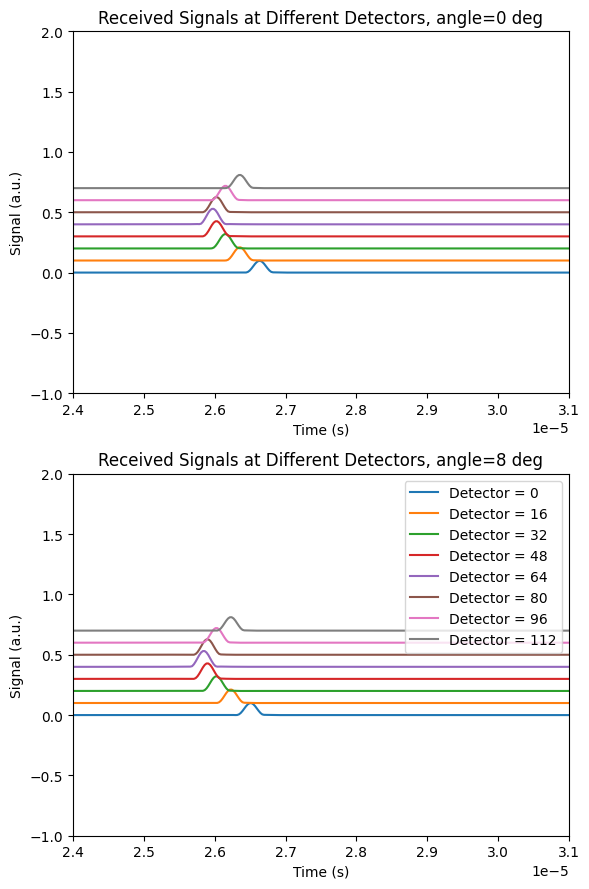

In [9]:
analytical_signals = scipy.signal.hilbert(real_signals, axis=-1)
envelope_signals = abs(analytical_signals)

x_rg = (2.4E-5, 3.1E-5)
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(times, envelope_signals[4, ::16, :].T + np.arange(8)[None, :] * .1)
plt.xlabel('Time (s)')
#plt.legend([f'Detector = {i}' for i in np.arange(0, 128, 16)])
plt.ylabel('Signal (a.u.)')
plt.title('Received Signals at Different Detectors, angle=0 deg')
plt.xlim(x_rg)
plt.ylim(-1, 2)

plt.subplot(2, 1, 2)
plt.plot(times, envelope_signals[0, ::16, :].T + np.arange(8)[None, :] * .1)
plt.xlabel('Time (s)')
plt.legend([f'Detector = {i}' for i in np.arange(0, 128, 16)])
plt.ylabel('Signal (a.u.)')
plt.title('Received Signals at Different Detectors, angle=8 deg')
plt.xlim(x_rg)
plt.ylim(-1, 2)
plt.tight_layout()

Since our simulation natively generates complex signals, there's no need to take their real part and then do the Hilbert transform to get back the complex analytical signal; we'll just use the native complex signal.

# Reconstruction

So how do we "properly" reconstruct images from the signals then? We use the same idea as above: for each location on the image, we calculate the time delays compatible with those locations for each transducer. Then we read the signal off from the analytical signal from the transducers compatible with these time delays, apply them back in image space, while factoring out the reference phase $\exp(i\omega t)$. Summing across transducers and angles gives us a complex image:

$$\tilde s(x, z) \in \mathbb{C}$$

This algorithm is called **delay-and-sum**. It's also known, confusingly, as **beamforming**; this is confusing because, well, we're not "forming the beam" during transmission, we're reversing the signal creation process to obtain an image; alas, this is accepted nomenclature.

The complex image is called by various names, including the complex beamformed signal or the complex [I/Q data](https://en.wikipedia.org/wiki/In-phase_and_quadrature_components). Taking the absolute value of this image forms a real envelope. The standard way of visualizing reconstructions is via the log of the real envelope. This image is sometimes called the B-mode image (B for brightness).

Text(0.5, 1.0, 'Reconstructed image (log)')

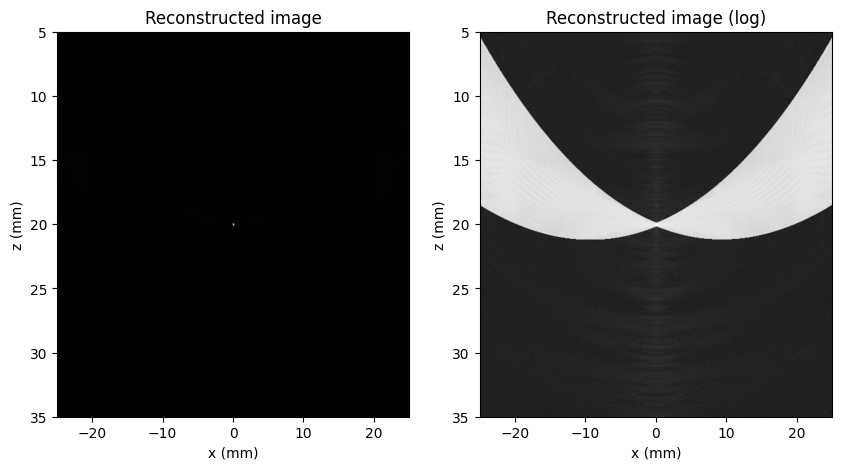

In [10]:
def make_image_grid(x_span, z_span, dx, dz):
    x = np.arange(x_span[0], x_span[1] + 1e-12, dx)
    z = np.arange(z_span[0], z_span[1] + 1e-12, dz)
    X, Z = np.meshgrid(x, z)  # (nz, nx)
    return x, z, X, Z

def beamform_das(
    Y,            # (M, Ne, K) complex RF (analytic) channels; M == len(betas)
    times,        # (K,) time stamps [s], uniform
    elem_pos,     # (Ne,) element x-positions [m], z=0
    x, z,         # image grids: x (nx,), z (nz,)
    c,            # speed of sound [m/s]
    betas,        # (M,) steering angles [rad], order must match Y's first dim
    alpha_np_per_m=None  # float or None. If set, apply exp(+alpha * path) TGC (two-way)
):
    M, Ne, K = Y.shape
    assert M == len(betas), "Y's first dim must match len(betas)."

    t0  = float(times[0])
    dt  = float(times[1] - times[0])

    # Precompute lateral offsets per row (nx, Ne), reused for all depths
    dx_row = x[:, None] - elem_pos[None, :]  # (nx, Ne)

    img = np.zeros((z.size, x.size), dtype=np.complex128)

    for m, beta in enumerate(betas):
        sin_beta, cos_beta = np.sin(beta), np.cos(beta)
        Y_m = Y[m]  # (Ne, K)

        for iz, zf in enumerate(z):
            # Two-way delay: τ_tot(x,n) = τ_rx(x,z; n) + τ_tx(x,z; θ)
            tau_rx = np.sqrt(dx_row**2 + zf**2) / c                    # (nx, Ne)
            tau_tx_row = (x * sin_beta + zf * cos_beta) / c                # (nx,)
            tau_tot = tau_rx + tau_tx_row[:, None]                      # (nx, Ne)

            # Nearest-neighbor sample
            k_idx = np.rint((tau_tot - t0) / dt).astype(np.int64)
            np.clip(k_idx, 0, K - 1, out=k_idx)

            # Gather and sum over elements (uniform weights)
            elem_idx = np.broadcast_to(np.arange(Ne)[None, :], k_idx.shape)
            samples = Y_m[elem_idx, k_idx]                              # (nx, Ne)

            # Exponential attenuation compensation (TGC): exp(+alpha * (r_tx + r_rx))
            if alpha_np_per_m is not None and alpha_np_per_m != 0.0:
                path_len = tau_tot * c            # (nx, Ne)
                tgc = np.exp(alpha_np_per_m * path_len)
                samples = samples * tgc

            row_sum = samples.mean(axis=1)
            img[iz, :] += row_sum

    return img  # complex image (before envelope/log)

# Field of view & grid (match your plotting extents)
x_span = (-0.025, 0.025)   # ±9 mm
z_span = (0.005, 0.035)    # 5–35 mm
x, z, X, Z = make_image_grid(x_span, z_span, 0.05e-3, 0.05e-3)

# Beamform (signals, times, elem_pos, betas, c all from your sim)
img_complex = beamform_das(signals, times, elem_pos, x, z, c, betas)

# Envelope & simple display
img_env = np.abs(img_complex)
img_env /= (img_env.max() + 1e-12)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(
    img_env,
    extent=[x[0]*1e3, x[-1]*1e3, z[-1]*1e3, z[0]*1e3],
    aspect='auto', cmap='gray'
)
plt.xlabel("x (mm)"); plt.ylabel("z (mm)"); plt.title("Reconstructed image")

plt.subplot(122)
plt.imshow(
    np.log(img_env),
    extent=[x[0]*1e3, x[-1]*1e3, z[-1]*1e3, z[0]*1e3],
    aspect='auto', cmap='gray'
)
plt.xlabel("x (mm)"); plt.ylabel("z (mm)"); plt.title("Reconstructed image (log)")


We've pin-pointed the exact location of the scatterer! In the log image (right), you can clearly see the pattern from the cones of confusion from the earlier sim.

# Image formation with many scatterers

With all of that, let's look at what happens when we have a dense volume of scatterers. Let's create a phantom containing many scatterers, but containing "empty" anechoic areas, and see if we can reconstruct the locations of these anechoic areas.

(-9.897955761511518, 9.899841684910765, 41.9990172073283, -1.9999532003489666)

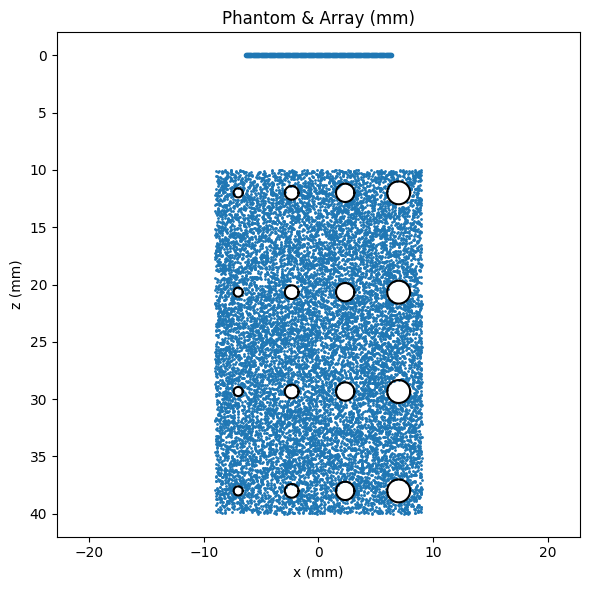

In [11]:
@dataclass
class SimParams:
    # Medium
    c: float = 1540.0

    # Probe
    Ne: int = 128
    pitch: float = 100e-6
    center_x: float = 0.0

    # TX / sampling
    f_carrier: float = 15e6
    fs: float = 60e6
    cycles: int = 14          # Hann-windowed burst length (baseband envelope)
    t_margin: float = 15e-6

    # Angles (deg)
    angles_deg: Tuple[float, ...] = (-8, -6, -4, -2, 0, 2, 4, 6, 8)

    # Propagation/element model
    use_2d_cylindrical: bool = True  # 2D amplitude ~ 1/sqrt(r); else 3D ~ 1/r
    alpha_db_cm_mhz: float = 0.58    # attenuation model (optional): dB/cm/MHz
    use_attenuation: bool = True

    x_span: Tuple[float, float] = (-9e-3, 9e-3)
    z_span: Tuple[float, float] = (10e-3, 40e-3)
    # Phantom (background + cyst grid)
    n_bg: int = 16000
    refl_bg: float = 1.0
    refl_inclusion: float = 0.0
    n_rows: int = 4
    n_cols: int = 4
    min_radius: float = 0.4e-3
    max_radius: float = 1.0e-3
    grid_margin: float = 2.0e-3

def make_array_positions(Ne: int, pitch: float, center_x: float) -> np.ndarray:
    idx = np.arange(Ne) - (Ne - 1)/2
    return center_x + idx * pitch   # (Ne,) x-positions at z=0

def inclusion_centers_radii(P: SimParams):
    x0, x1 = P.x_span; z0, z1 = P.z_span
    gx0, gx1 = x0 + P.grid_margin, x1 - P.grid_margin
    gz0, gz1 = z0 + P.grid_margin, z1 - P.grid_margin
    xs = np.linspace(gx0, gx1, P.n_cols)
    zs = np.linspace(gz0, gz1, P.n_rows)
    Xc, Zc = np.meshgrid(xs, zs)
    centers = np.column_stack([Xc.ravel(), Zc.ravel()])
    radii_line = np.linspace(P.min_radius, P.max_radius, P.n_cols)
    radii = np.tile(radii_line, P.n_rows)
    return centers, radii

def sample_scatterers(P: SimParams, rng=np.random.default_rng(0)):
    xs = rng.uniform(P.x_span[0], P.x_span[1], P.n_bg)
    zs = rng.uniform(P.z_span[0], P.z_span[1], P.n_bg)
    scat_pos = np.column_stack([xs, zs]).astype(np.float64)  # (S,2)
    amp = np.full(P.n_bg, P.refl_bg, dtype=np.float64)

    centers, radii = inclusion_centers_radii(P)
    for (cx, cz), R in zip(centers, radii):
        inside = (scat_pos[:,0]-cx)**2 + (scat_pos[:,1]-cz)**2 <= R**2
        amp[inside] = P.refl_inclusion
    return scat_pos, amp

P = SimParams()

elem_pos = make_array_positions(P.Ne, P.pitch, P.center_x)
scat_pos, scat_amp = sample_scatterers(P)                   # (S,2), (S,)

# 1) Plot the phantom (scatterers + inclusion outlines + array)
plt.figure(figsize=(6, 6))
plt.scatter(scat_pos[scat_amp == 1,0]*1e3, scat_pos[scat_amp == 1,1]*1e3, s=1)
centers, Radii = inclusion_centers_radii(P)
for (cx, cz), R in zip(centers, Radii):
    th = np.linspace(0, 2*np.pi, 200)
    plt.plot((cx + R*np.cos(th))*1e3, (cz + R*np.sin(th))*1e3, 'k')
plt.plot(elem_pos*1e3, np.zeros_like(elem_pos)*1e3, 'o', markersize=3)
plt.gca().invert_yaxis()
plt.title("Phantom & Array (mm)")
plt.xlabel("x (mm)"); plt.ylabel("z (mm)")
plt.tight_layout()
plt.axis('equal')

Let's simulate the scatterers and reconstruct the image as before.

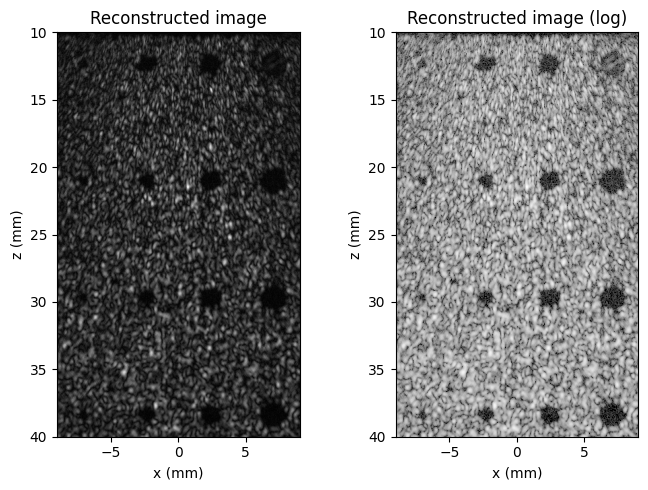

In [12]:
def hann_burst_envelope(f0: float, cycles: int, fs: float) -> np.ndarray:
    """
    Baseband envelope s(t) using numpy's np.hanning with length ≈ cycles * fs / f0.
    Returns a unit-energy window.
    """
    Nt = max(int(round(cycles * fs / f0)), 1)
    s = np.hanning(Nt).astype(np.float64)
    e = np.sqrt(np.sum(s**2))
    return s / e if e > 0 else s

def simulate_forward_channels(P: SimParams):
    c = P.c
    elem_pos = make_array_positions(P.Ne, P.pitch, P.center_x)      # (Ne,)
    betas = np.deg2rad(np.array(P.angles_deg, dtype=np.float64))   # (M,)
    s_env = hann_burst_envelope(P.f_carrier, P.cycles, P.fs)
    M, Ne = len(betas), P.Ne

    # Phantom
    scat_pos, scat_amp = sample_scatterers(P)   # (S,2), (S,)
    S = scat_pos.shape[0]

    # Times (enough to cover max delay + envelope + margin)
    # Worst-case: far corner of FOV for TX + RX to far-most element
    # Max TX delay over angles at FOV far corner:
    x_far, z_far = P.x_span[1], P.z_span[1]
    tx_max = np.max([(x_far*np.sin(beta) + z_far*np.cos(beta)) / c for beta in betas])
    # Max RX delay across elements for far scatterers:
    dx = scat_pos[:,0][:,None] - elem_pos[None,:]
    r  = np.sqrt(dx*dx + scat_pos[:,1][:,None]**2)
    rx_max = r.max() / c
    K = int(np.ceil((tx_max + rx_max + len(s_env)/P.fs + P.t_margin) * P.fs))
    times = np.arange(K) / P.fs

    # Attenuation coefficient (Np/m)
    if P.use_attenuation:
        alpha = (P.alpha_db_cm_mhz * (P.f_carrier/1e6) * 100.0) / 8.686
    else:
        alpha = 0.0

    # Precompute geometry
    k = 2*np.pi*P.f_carrier / c
    b = P.pitch/2  # element half-width for directivity
    # Spreading factor function
    if P.use_2d_cylindrical:
        spread = lambda r_: 1.0/np.sqrt(np.maximum(r_, 1e-9))
        cyl_phase = np.exp(-1j*np.pi/4)  # optional 2D phase; keep for “more right”
    else:
        spread = lambda r_: 1.0/np.maximum(r_, 1e-9)
        cyl_phase = 1.0 + 0j

    # Output
    signals = np.zeros((M, Ne, K), dtype=np.complex128)

    # Vector helpers reused in loops
    x_s = scat_pos[:,0]            # (S,)
    z_s = scat_pos[:,1]            # (S,)

    for i, beta in enumerate(betas):
        # TX delay to each scatterer (S,)

        r_tx = (x_s*np.sin(beta) + z_s*np.cos(beta))
        tau_tx = r_tx / c

        for n in range(Ne):
            # RX distance & delay from scatterers to element n
            r_rx = np.sqrt((x_s - elem_pos[n])**2 + z_s**2)      # (S,)
            tau_rx = r_rx / c
            tau_tot = tau_tx + tau_rx

            # Amplitude: attenuation * spreading * element directivity (receive)
            directivity = np.sinc((k * b * (x_s - elem_pos[n]) / r_rx) / np.pi)
            amp_mag = scat_amp * spread(r_rx) * np.exp(-alpha * (r_tx + r_rx))
            phase   = cyl_phase * np.exp(-1j * 2*np.pi * P.f_carrier * tau_tot)
            amps    = amp_mag * directivity * phase              # (S,)

            # Fractional-delay spike train (two-tap linear)
            g = np.zeros(K, dtype=np.complex128)
            kf = tau_tot * P.fs
            k0 = np.floor(kf).astype(np.int64)
            frac = kf - k0
            # lower
            valid0 = (k0 >= 0) & (k0 < K)
            np.add.at(g, k0[valid0], amps[valid0] * (1.0 - frac[valid0]))
            # upper
            k1 = k0 + 1
            valid1 = (k1 >= 0) & (k1 < K)
            np.add.at(g, k1[valid1], amps[valid1] * frac[valid1])

            # Convolve with envelope and crop
            y = fftconvolve(g, s_env, mode='full')[:K]
            signals[i, n, :] = y * np.exp(1j * 2*np.pi * P.f_carrier * times)

    return signals, times, elem_pos, betas, scat_pos, s_env

signals, times, elem_pos, betas, scat_pos, s_env = simulate_forward_channels(P)

# Image grid
x, z, X, Z = make_image_grid(P.x_span, P.z_span, 0.05e-3, 0.05e-3)

# Beamform (names harmonized with your earlier code)
img_complex = beamform_das(signals, times, elem_pos, x, z, P.c, betas, alpha_np_per_m=alpha)

# Envelope / log for display
img_env = np.abs(img_complex)
img_env /= (img_env.max() + 1e-12)
img_log = 20*np.log10(img_env + 1e-6)
img_log = np.clip(img_log, -60, 0)

plt.figure(figsize=(7,5))
plt.subplot(121)
plt.imshow(
    img_env,
    extent=[x[0]*1e3, x[-1]*1e3, z[-1]*1e3, z[0]*1e3],
    aspect='equal', cmap='gray'
)
plt.xlabel("x (mm)"); plt.ylabel("z (mm)"); plt.title("Reconstructed image")

plt.subplot(122)
plt.imshow(
    img_log,
    extent=[x[0]*1e3, x[-1]*1e3, z[-1]*1e3, z[0]*1e3],
    aspect='equal', cmap='gray', vmin=-40, vmax=0
)
plt.xlabel("x (mm)"); plt.ylabel("z (mm)"); plt.title("Reconstructed image (log)")
plt.tight_layout()

As you can see, the macroscopic anechoic inclusions in the field of scatterers is visible (although the 400 μm inclusions are harder to resolve). However, the *scatterers* are no longer individually resolvable, but rather merge into each other. The pattern of constructive and destructive interference is called **speckle**. Notice that the apparent size of the grain of the speckle also tends to increase with depth.

Note that we've added a correction for exponential attenuation, but not for the $1/\sqrt{r}$ effect or the angular sensitivity of the measurements. Although we could add these in, in the real world, this would tend to accentuate noise in the image. There are a lot of subtleties about the delay-and-sum algorithm, but a very general way of thinking about it is as a way of approximately solving the image reconstruction problem:

$$y = X\tilde s + \epsilon$$

where $\tilde s$ is the (complex) image to solve for, $y$ are the stacked measurements, $X$ captures the sensitivity functions (bringing together the conics of confusion, angular sensitivity, attenuation and distance falloff), and $\epsilon$ is a noise model. The delay-and-sum algorithm uses the adjoint (i.e., $w \approx cX^Ty$) as an approximate solution of a simplified forward model; it's a fast but crude estimator of $\tilde s$. 

One could instead directly solve for the maximum likelihood solution or MAP image under the noise model, ideally regularizing image weights $w$ to prevent noise from blowing up the reconstruction. Theses types of solutions are generally more expensive to compute, but may be useful under certain imaging conditions.

# References

* [Szabo 2013](https://www.amazon.com/Diagnostic-Ultrasound-Imaging-Biomedical-Engineering/dp/0123964873). Diagnostic Ultrasound.
* [Besson et al. 2015](https://scispace.com/pdf/ultrafast-ultrasound-imaging-as-an-inverse-problem-matrix-20px53ozy6.pdf). Ultrafast ultrasound imaging as an inverse problem: Matrix-free sparse image reconstruction.